In [1]:
%run init_notebook.py

In [2]:
import pickle
import spacy

import numpy as np
import guidedlda
import gensim.corpora as corpora
import gensim
import pyLDAvis.gensim
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer
import time

In [3]:
from src.utils import load_pickle

# load narratives

In [4]:
from articles import DICT_NARRATIVES
lst_topic_seeds = [[*chain(*list(v.values()))] for k, v in DICT_NARRATIVES.items()]

ModuleNotFoundError: No module named 'patsy'

In [ ]:
for word in ['chain', 'zinsrate']:
    for idx, lst in enumerate(lst_topic_seeds):
        if word in lst:
            lst_topic_seeds[idx].remove(word)

# load data

In [40]:
LST_FREQUENT_NON_MEANING = [
    'prozent',
     'euro',
     'million',
     'milliarde',
     'deutschland',
     'deutsch',
     'land',
     'firma',
     'frage',
    'zahl',
    'woche',
    'monat',
    'stadt',
    'bereich',
    'seite',
    'datum',
    'quartal',
    'tonne',
    'zeit',
    'entwicklung',
    'standort',
    "vergleich", "jahr", "experte", "anfangm", "lage", "thema", "anteil", "blick", "weg", "meinungen", "punkt", "januar", "september", "maßnahme", "juni", "situation", "hälfte", 
"angabe", "jahrzehnt", "juli", "institut", "region", "vorjahr", "frau", "april",
    "kilometer", "dienstag", "system", "familie", "mitt", "gespräch", "mai", "niveau", "oktober", "lösung", "modell", "idee", "dezember", "prognose", "papier", "drittel", "schnitt", 
"mal", "strategie", "november", "platz", "mittwoch", "montag", "stelle", "august", "februar", "teil", "stunde", "hand", "name", "freitag", "halbjahr", "umfrage", "prozentpunkt", 
"stand", "wort", "summe",
]

In [41]:
dict_txts = {}
for file in [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']][:1000]:
    dict_txts[file.split('.')[0]] = load_pickle(file)

In [42]:
lst_noun_tokens = [list(i['counter_nouns'].keys()) for i in dict_txts.values()] # i['date'] >= datetime(2012,1,1).date()]
lst_noun_tokens = [[i for i in lst if i not in LST_FREQUENT_NON_MEANING] for lst in lst_noun_tokens]

# guided lda

In [49]:
voc = list(set([*chain(*lst_noun_tokens)]))

In [43]:
vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=voc)
vec = vectorizer.fit_transform([" ".join(i) for i in lst_noun_tokens])
X = vec.toarray()
word2id=vectorizer.vocabulary_

# guided lda

In [44]:
glda = guidedlda.GuidedLDA(
    n_topics=len(lst_topic_seeds), 
    # topic_word_prior=prior.T,
    # learning_decay=.7,
    # learning_offset=10,
    # learning_method='online',
    # batch_size=5_000,
    random_state=101,
)

In [45]:
%%capture
seed_topics = {}
for t_id, st in enumerate(lst_topic_seeds):
    for word in st:
        seed_topics[word2id[word]] = t_id

glda.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 34495
INFO:guidedlda:n_words: 119848
INFO:guidedlda:n_topics: 9
INFO:guidedlda:n_iter: 2000
INFO:guidedlda:<0> log likelihood: -1582512
INFO:guidedlda:<10> log likelihood: -1333741
INFO:guidedlda:<20> log likelihood: -1308232
INFO:guidedlda:<30> log likelihood: -1294328
INFO:guidedlda:<40> log likelihood: -1283412
INFO:guidedlda:<50> log likelihood: -1274028
INFO:guidedlda:<60> log likelihood: -1267883
INFO:guidedlda:<70> log likelihood: -1263026
INFO:guidedlda:<80> log likelihood: -1260030
INFO:guidedlda:<90> log likelihood: -1255883
INFO:guidedlda:<100> log likelihood: -1254109
INFO:guidedlda:<110> log likelihood: -1252272
INFO:guidedlda:<120> log likelihood: -1250082
INFO:guidedlda:<130> log likelihood: -1249053
INFO:guidedlda:<140> log likelihood: -1248053
INFO:guidedlda:<150> log likelihood: -1246757
INFO:guidedlda:<160> log likelihood: -1246244
INFO:guidedlda:<170> log likelihood: -1245656
INFO:guidedlda:<180> log likeli

In [55]:
lst_topic_seeds[1]

['beschäftigter',
 'mitarbeiter',
 'arbeitnehmer',
 'gehalt',
 'lohn',
 'arbeitslosigkeit',
 'arbeitslosenquote',
 'arbeitslosenzahl']

In [50]:
n_top_words = len(lst_topic_seeds)
topic_word = glda.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(voc)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: kunde preis handel mensch händler produkt branche betrieb lebensmittel
Topic 1: preis mann art haus bild ausland bayern hotel münchen
Topic 2: wohnung immobilie miete haus preis münchen quadratmeter markt wohnen
Topic 3: auto fahrzeug hersteller elektroauto volkswagen vw batterie bmw autohersteller
Topic 4: wirtschaft usa preis inflation dollar europa china folge bank
Topic 5: unternehmen konzern umsatz markt geschäft fakten europa kunde usa
Topic 6: aktie börse anleger gewinn kurs dax investor bank bewertung
Topic 7: energie strom gas bundesregierung preis unternehmen industrie investition strompreis
Topic 8: geld fall unternehmen mensch kosten problem berlin politik grund


In [52]:
df = pd.DataFrame(glda.doc_topic_, index=[i['date'] for i in dict_txts.values()]).sort_index() # if i['date'] >= datetime(2012,1,1)]).sort_index()

<AxesSubplot:>

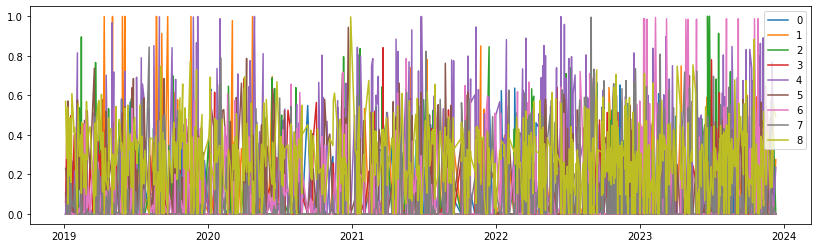

In [53]:
df.plot(figsize=(14,4))